# Stations selection

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import multiprocessing
import os
from sklearn.preprocessing import MinMaxScaler
import warnings

<br>

### Only one meteorological predictor: temperature

In [2]:
meteorological_data = pd.read_csv("weather/weather_data.csv", usecols=['time', 'temperature_2m (°C)', 'city', 'region'])
meteorological_data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)

energy_data = pd.read_csv('electricity/eco2mix_data.csv', usecols=['time', 'Périmètre', 'Consommation'])
energy_data.rename(columns={'Périmètre': 'region'}, inplace=True)

combined_data = pd.merge(meteorological_data, energy_data, on=['time', 'region'])

<br>

Let's add **month**, **day of the week** and **hour** variables.

In [3]:
combined_data['time'] = pd.to_datetime(combined_data['time'], format='%Y-%m-%d %H:%M:%S')

combined_data['Month'] = combined_data['time'].dt.month.astype('category')
combined_data['DayOfWeek'] = combined_data['time'].dt.dayofweek.astype('category')
combined_data['Hour'] = combined_data['time'].dt.hour.astype('category')

combined_data[combined_data['city']=='Annecy'].head(5)

,time,temperature,region,city,Consommation,Month,DayOfWeek,Hour
0,2013-01-01 00:00:00,1.50,Auvergne-Rhône-Alpes,Annecy,8173.0,1,1,0
10,2013-01-01 00:30:00,1.40,Auvergne-Rhône-Alpes,Annecy,8173.0,1,1,0
20,2013-01-01 01:00:00,1.30,Auvergne-Rhône-Alpes,Annecy,7944.0,1,1,1
30,2013-01-01 01:30:00,1.25,Auvergne-Rhône-Alpes,Annecy,7896.0,1,1,1
40,2013-01-01 02:00:00,1.20,Auvergne-Rhône-Alpes,Annecy,7882.0,1,1,2


<br>

We will also consider the **trend** in our data. 

To do this, we will introduce a new variable representing the index of each observation. This way, the first half hour of 2013 will be equal to 1, whereas the last of 2020 will be 140,256.

In [4]:
combined_data.sort_values(by=['city', 'time'], inplace=True)
combined_data['trend'] = combined_data.groupby('city').cumcount() + 1

combined_data[combined_data['city'] == 'Annecy'].head(5)

,time,temperature,region,city,Consommation,Month,DayOfWeek,Hour,trend
0,2013-01-01 00:00:00,1.50,Auvergne-Rhône-Alpes,Annecy,8173.0,1,1,0,1
10,2013-01-01 00:30:00,1.40,Auvergne-Rhône-Alpes,Annecy,8173.0,1,1,0,2
20,2013-01-01 01:00:00,1.30,Auvergne-Rhône-Alpes,Annecy,7944.0,1,1,1,3
30,2013-01-01 01:30:00,1.25,Auvergne-Rhône-Alpes,Annecy,7896.0,1,1,1,4
40,2013-01-01 02:00:00,1.20,Auvergne-Rhône-Alpes,Annecy,7882.0,1,1,2,5


<br>

In [5]:
combined_data[combined_data['city']=='Annecy'].tail(5)

,time,temperature,region,city,Consommation,Month,DayOfWeek,Hour,trend
1402520,2020-12-31 22:00:00,1.30,Auvergne-Rhône-Alpes,Annecy,8156.0,12,3,22,140253
1402530,2020-12-31 22:30:00,1.25,Auvergne-Rhône-Alpes,Annecy,8398.0,12,3,22,140254
1402540,2020-12-31 23:00:00,1.20,Auvergne-Rhône-Alpes,Annecy,8690.0,12,3,23,140255
1402550,2020-12-31 23:30:00,1.20,Auvergne-Rhône-Alpes,Annecy,8834.0,12,3,23,140256
1402551,2020-12-31 23:30:00,1.20,Auvergne-Rhône-Alpes,Annecy,8834.0,12,3,23,140257


<br>

We will employ the **Tao’s vanilla benchmark model**:

\begin{equation}
y_{t} = \beta_{0} + \beta_{1} \text{Trend}_{t} + \beta_{2} M_{t} + \beta_{3} W_{t} + \beta_{4} H_{t} + \beta_{5} W_{t}H_{t} + f(T_{t})
\end{equation}

where: 
- $y_t$ is the load forecast for time $t$
- $M_t$, $W_t$ and $H_t$ are the month, day of the week and hour classification variables corresponding to time $t$, respectively
- $T_t$ is the temperature at time $t$
- $f(T_{t}) = \beta_{6} T_{t} + \beta_{7} T_{t}^{2} + \beta_{8} T_{t}^{3} + \beta_{9} T_{t}M_{t} + \beta_{10} T_{t}^{2} M_{t} + \beta_{11} T_{t}^{3} M_{t} + \beta_{12} T_{t} H_{t} + \beta_{13} T_{t}^{2} H_{t} + \beta_{14} T_{t}^{3} H_{t}.$


In [6]:
def load_forecast_model(data):  
    formula = "Consommation ~ trend + C(Month) + C(DayOfWeek) + C(Hour) + C(DayOfWeek) * C(Hour)  + \
                    temperature + np.power(temperature, 2) + np.power(temperature, 3) + \
                    temperature * C(Month) + np.power(temperature, 2) * C(Month) + np.power(temperature, 3) * C(Month) + \
                    temperature * C(Hour) + np.power(temperature, 2) * C(Hour) + np.power(temperature, 3) * C(Hour)"
        
    model = sm.formula.ols(formula=formula, data=data).fit()
    
    return model

<br>

In [7]:
def in_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_train = model.predict(train_data)
    mape_in_sample = mean_absolute_percentage_error(train_data['Consommation'], y_pred_train)
    
    return mape_in_sample

def out_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_test = model.predict(test_data)
    mape_out_sample = mean_absolute_percentage_error(test_data['Consommation'], y_pred_test)
    
    return mape_out_sample

<br>

### Fixed number of stations: N=3

In [ ]:
selected_stations = {}

for region, region_data in grouped_data:
    print("\n" + region + ":")
    region_stations = region_data['city'].unique()

    station_errors = {}
    for station in region_stations:
        station_data = region_data[region_data['city'] == station]
        error = in_sample_error(station_data)
        station_errors[station] = error

    k_best_stations = sorted(station_errors.keys(), key=lambda x: station_errors[x])[:5]  
    print("Top 5 stations with the lowest MSE:", k_best_stations)

    lowest_error = float('inf')
    best_stations = None

    for combo in combinations(k_best_stations, 3):
        selected_data = region_data[region_data['city'].isin(combo)] 

        temperatures = selected_data[['time', 'temperature']]
        mean_temperatures = {}

        for time, group in temperatures.groupby('time'):
            mean_temp = np.mean(group['temperature'])
            mean_temperatures[time] = mean_temp

        city = selected_data.iloc[0]['city']
        data = selected_data[selected_data['city'] == city].copy()

        for time, mean_temp in mean_temperatures.items():
            data.loc[data['time'] == time, 'temperature'] = mean_temp

        error = out_sample_error(data)
        
        if error < lowest_error:
            lowest_error = error
            best_stations = combo
                
    selected_stations[region] = best_stations
    print("Best combination:", best_stations)

<br>

### Non fixed number of stations: 1<N<5

In [ ]:
selected_stations = {}

for region, region_data in grouped_data:
    print("\n" + region + ":")
    region_stations = region_data['city'].unique()

    station_errors = {}
    for station in region_stations:
        station_data = region_data[region_data['city'] == station]
        error = in_sample_error(station_data)
        station_errors[station] = error

    k_best_stations = sorted(station_errors.keys(), key=lambda x: station_errors[x])[:4]  
    print("Top 4 stations with the lowest MSE:", k_best_stations)

    lowest_error = float('inf')
    best_stations = None

    for N in range(1, 5):  
        for combo in combinations(k_best_stations, N):
            selected_data = region_data[region_data['city'].isin(combo)] 
    
            temperatures = selected_data[['time', 'temperature']]
            mean_temperatures = {}
    
            for time, group in temperatures.groupby('time'):
                mean_temp = np.mean(group['temperature'])
                mean_temperatures[time] = mean_temp
    
            city = selected_data.iloc[0]['city']
            data = selected_data[selected_data['city'] == city].copy()
    
            for time, mean_temp in mean_temperatures.items():
                data.loc[data['time'] == time, 'temperature'] = mean_temp
    
            error = out_sample_error(data)
            
            if error < lowest_error:
                lowest_error = error
                best_stations = combo
                
    selected_stations[region] = best_stations
    print("Best combination:", best_stations)

<br>

### Parallelization 
Code executed in spyder.



#### Fixed number of stations: N=3

In [ ]:
import multiprocessing
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

meteorological_data = pd.read_csv("weather/weather_data.csv", usecols=['time', 'temperature_2m (°C)', 'city', 'region'])
meteorological_data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)

energy_data = pd.read_csv('electricity/eco2mix_data.csv', usecols=['time', 'Périmètre', 'Consommation'])
energy_data.rename(columns={'Périmètre': 'region'}, inplace=True)

combined_data = pd.merge(meteorological_data, energy_data, on=['time', 'region'])

combined_data['time'] = pd.to_datetime(combined_data['time'], format='%Y-%m-%d %H:%M:%S')

combined_data['Month'] = combined_data['time'].dt.month.astype('category')
combined_data['DayOfWeek'] = combined_data['time'].dt.dayofweek.astype('category')
combined_data['Hour'] = combined_data['time'].dt.hour.astype('category')

combined_data.sort_values(by=['city', 'time'], inplace=True)
combined_data['trend'] = combined_data.groupby('city').cumcount() + 1

grouped_data = combined_data.groupby('region')

def load_forecast_model(data):  
    formula = "Consommation ~ trend + C(Month) + C(DayOfWeek) + C(Hour) + C(DayOfWeek) * C(Hour)  + \
                    temperature + np.power(temperature, 2) + np.power(temperature, 3) + \
                    temperature * C(Month) + np.power(temperature, 2) * C(Month) + np.power(temperature, 3) * C(Month) + \
                    temperature * C(Hour) + np.power(temperature, 2) * C(Hour) + np.power(temperature, 3) * C(Hour)"
        
    model = sm.formula.ols(formula=formula, data=data).fit()
    
    return model

def in_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_train = model.predict(train_data)
    mape_in_sample = mean_absolute_percentage_error(train_data['Consommation'], y_pred_train)
    
    return mape_in_sample

def out_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_test = model.predict(test_data)
    mape_out_sample = mean_absolute_percentage_error(test_data['Consommation'], y_pred_test)
    
    return mape_out_sample
    
def process_region(region, region_data, result_queue):
    region_stations = region_data['city'].unique()

    station_errors = {}
    for station in region_stations:
        station_data = region_data[region_data['city'] == station]
        error = in_sample_error(station_data)
        station_errors[station] = error

    k_best_stations = sorted(station_errors.keys(), key=lambda x: station_errors[x])[:5]  

    lowest_error = float('inf')
    best_stations = None

    for combo in combinations(k_best_stations, 3):        
        selected_data = region_data[region_data['city'].isin(combo)] 
        temperatures = selected_data[['time', 'temperature']]
        mean_temperatures = {}

        for time, group in temperatures.groupby('time'):
            mean_temp = np.mean(group['temperature'])
            mean_temperatures[time] = mean_temp

        city = selected_data.iloc[0]['city']
        data = selected_data[selected_data['city'] == city].copy()

        for time, mean_temp in mean_temperatures.items():
            data.loc[data['time'] == time, 'temperature'] = mean_temp

        error = out_sample_error(data)
        
        if error < lowest_error:
            lowest_error = error
            best_stations = combo
                
    result_queue.put((region, best_stations))

if __name__ == '__main__':
    manager = multiprocessing.Manager()
    result_queue = manager.Queue()

    processes = []
    for region, region_data in grouped_data:
        process = multiprocessing.Process(target=process_region, args=(region, region_data, result_queue))
        processes.append(process)
        process.start()
    
    for process in processes:
        process.join()

    selected_stations = {}
    while not result_queue.empty():
        region, best_stations = result_queue.get()
        selected_stations[region] = best_stations

    print("\nSelected Stations:")
    for region, best_stations in selected_stations.items():
        print(f"{region}: {best_stations}")   

**Output**:

- Auvergne-Rhône-Alpes: ('Saint-Chamond', 'Lyon', 'Annecy')

- Bourgogne-Franche-Comté: ('Besançon', 'Mâcon', 'Dijon')

- Bretagne: ('Dinan', 'Rennes', 'Quimper')

- Centre-Val de Loire: ('Tours', 'Blois', 'Orléans')

- Grand-Est: ('Verdun', 'Estrasburgo', 'Nancy')

- Hauts-de-France: ('Reims', 'Charleville-Mézières', 'Compiègne')

- Ile-de-France: ('Pontoise', 'Versailles', 'Évry-Courcouronnes')

- Normandie: ('Alençon', 'Évreux', 'Le Havre')

- Nouvelle-Aquitaine: ('Périgueux', 'Agen', 'Limoges')

- Occitanie: ('Toulouse', 'Nimes', 'Béziers')

- PACA: ('Aix-en-Provence', 'Avignon', 'Toulon')

- Pays-de-la-Loire: ('Ancenis', 'Saumur', 'Cholet')

<br>

<br>

#### Non fixed number of stations: 1<N<5

In [ ]:
import multiprocessing
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

meteorological_data = pd.read_csv("weather/weather_data.csv", usecols=['time', 'temperature_2m (°C)', 'city', 'region'])
meteorological_data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)

energy_data = pd.read_csv('electricity/eco2mix_data.csv', usecols=['time', 'Périmètre', 'Consommation'])
energy_data.rename(columns={'Périmètre': 'region'}, inplace=True)

combined_data = pd.merge(meteorological_data, energy_data, on=['time', 'region'])

combined_data['time'] = pd.to_datetime(combined_data['time'], format='%Y-%m-%d %H:%M:%S')

combined_data['Month'] = combined_data['time'].dt.month.astype('category')
combined_data['DayOfWeek'] = combined_data['time'].dt.dayofweek.astype('category')
combined_data['Hour'] = combined_data['time'].dt.hour.astype('category')

combined_data.sort_values(by=['city', 'time'], inplace=True)
combined_data['trend'] = combined_data.groupby('city').cumcount() + 1

grouped_data = combined_data.groupby('region')

def load_forecast_model(data):  
    formula = "Consommation ~ trend + C(Month) + C(DayOfWeek) + C(Hour) + C(DayOfWeek) * C(Hour)  + \
                    temperature + np.power(temperature, 2) + np.power(temperature, 3) + \
                    temperature * C(Month) + np.power(temperature, 2) * C(Month) + np.power(temperature, 3) * C(Month) + \
                    temperature * C(Hour) + np.power(temperature, 2) * C(Hour) + np.power(temperature, 3) * C(Hour)"
        
    model = sm.formula.ols(formula=formula, data=data).fit()
    
    return model

def in_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_train = model.predict(train_data)
    mape_in_sample = mean_absolute_percentage_error(train_data['Consommation'], y_pred_train)
    
    return mape_in_sample

def out_sample_error(data):
    train_data = data[data['time'].dt.year <= 2019]
    test_data = data[data['time'].dt.year == 2020]
    
    model = load_forecast_model(train_data)
    
    y_pred_test = model.predict(test_data)
    mape_out_sample = mean_absolute_percentage_error(test_data['Consommation'], y_pred_test)
    
    return mape_out_sample
    
def process_region(region, region_data, result_queue):
    region_stations = region_data['city'].unique()

    station_errors = {}
    for station in region_stations:
        station_data = region_data[region_data['city'] == station]
        error = in_sample_error(station_data)
        station_errors[station] = error

    k_best_stations = sorted(station_errors.keys(), key=lambda x: station_errors[x])[:5]  

    lowest_error = float('inf')
    best_stations = None

    for N in range(1, 5):  
        for combo in combinations(k_best_stations, N):        
            selected_data = region_data[region_data['city'].isin(combo)] 
            temperatures = selected_data[['time', 'temperature']]
            mean_temperatures = {}
    
            for time, group in temperatures.groupby('time'):
                mean_temp = np.mean(group['temperature'])
                mean_temperatures[time] = mean_temp
    
            city = selected_data.iloc[0]['city']
            data = selected_data[selected_data['city'] == city].copy()
    
            for time, mean_temp in mean_temperatures.items():
                data.loc[data['time'] == time, 'temperature'] = mean_temp
    
            error = out_sample_error(data)
            
            if error < lowest_error:
                lowest_error = error
                best_stations = combo
                
    result_queue.put((region, best_stations))

if __name__ == '__main__':
    manager = multiprocessing.Manager()
    result_queue = manager.Queue()

    processes = []
    for region, region_data in grouped_data:
        process = multiprocessing.Process(target=process_region, args=(region, region_data, result_queue))
        processes.append(process)
        process.start()
    
    for process in processes:
        process.join()

    selected_stations = {}
    while not result_queue.empty():
        region, best_stations = result_queue.get()
        selected_stations[region] = best_stations

    print("\nSelected Stations:")
    for region, best_stations in selected_stations.items():
        print(f"{region}: {best_stations}")   

**Output**:

- Auvergne-Rhône-Alpes: ('Saint-Chamond', 'Lyon', 'Annecy')   $\rightarrow N=3$
  
- **Bourgogne-Franche-Comté**: ('Besançon', 'Dijon')   $\rightarrow N=2$
  
- **Bretagne**: ('Redon', 'Dinan', 'Rennes', 'Quimper')   $\rightarrow N=4$

- **Centre-Val de Loire**: 'Tours'   $\rightarrow N=1$

- **Grand-Est**: ('Verdun', 'Estrasburgo')  $\rightarrow N=2$

- **Hauts-de-France**: ('Charleville-Mézières', 'Compiègne')  $\rightarrow N=2$

- **Ile-de-France**: 'Pontoise'  $\rightarrow N=1$

- **Normandie**: ('Alençon', 'Le Havre')  $\rightarrow N=2$

- **Nouvelle-Aquitaine**: ('Périgueux', 'Limoges')  $\rightarrow N=2$

- **Occitanie**: ('Carcassonne', 'Toulouse', 'Nimes', 'Béziers')  $\rightarrow N=4$

- PACA: ('Aix-en-Provence', 'Avignon', 'Toulon') $\rightarrow N=3$

- **Pays-de-la-Loire**: ('Saumur', 'Cholet')  $\rightarrow N=2$

<br>

The highlighted results indicate instances where the optimal combination differs from previous findings, that is, N $\neq$ 3.


In summary, only one region retains its optimal combination with N=3, while the majority show reduced errors with N=2.

<br>

## Creating final dataset

To do this, we will employ the best combinations obtained from the last approach, with non fixed N.

In [8]:
best_combinations = {
    'Auvergne-Rhône-Alpes': ('Saint-Chamond', 'Lyon', 'Annecy'),
    'Bourgogne-Franche-Comté': ('Besançon', 'Dijon'),
    'Bretagne': ('Redon', 'Dinan', 'Rennes', 'Quimper'),
    'Centre-Val de Loire': ('Tours',),
    'Grand-Est': ('Verdun', 'Estrasburgo'),
    'Hauts-de-France': ('Charleville-Mézières', 'Compiègne'),
    'Ile-de-France': ('Pontoise',),
    'Normandie': ('Alençon', 'Le Havre'),
    'Nouvelle-Aquitaine': ('Périgueux', 'Limoges'),
    'Occitanie': ('Carcassonne', 'Toulouse', 'Nimes', 'Béziers'),
    'PACA': ('Aix-en-Provence', 'Avignon', 'Toulon'),
    'Pays-de-la-Loire': ('Saumur', 'Cholet')
}

<br>

Now, we will introduce all available meteorological data.

In [9]:
meteorological_data = pd.read_csv("weather/weather_data.csv")
meteorological_data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)
meteorological_data.rename(columns={'relative_humidity_2m (%)': 'relative_humidity'}, inplace=True)
meteorological_data.rename(columns={'apparent_temperature (°C)': 'apparent_temperature'}, inplace=True)
meteorological_data.rename(columns={'weather_code (wmo code)': 'weather_code'}, inplace=True)

energy_data = pd.read_csv('electricity/eco2mix_data.csv', usecols=['time', 'Périmètre', 'Consommation'])
energy_data.rename(columns={'Périmètre': 'region'}, inplace=True)
energy_data.rename(columns={'Consommation': 'consumption'}, inplace=True)


combined_data = pd.merge(meteorological_data, energy_data, on=['time', 'region'])
combined_data['time'] = pd.to_datetime(combined_data['time'], format='%Y-%m-%d %H:%M:%S')
grouped_data = combined_data.groupby('region')

combined_data.head(5)

,time,temperature,relative_humidity,apparent_temperature,weather_code,region,city,consumption
0,2013-01-01,1.5,83.0,-1.5,2,Auvergne-Rhône-Alpes,Annecy,8173.0
1,2013-01-01,-9.6,57.0,-14.0,1,Auvergne-Rhône-Alpes,Chambéry,8173.0
2,2013-01-01,2.0,75.0,-3.8,3,Auvergne-Rhône-Alpes,Clermont-Ferrand,8173.0
3,2013-01-01,5.3,77.0,1.8,1,Auvergne-Rhône-Alpes,Grenoble,8173.0
4,2013-01-01,6.8,80.0,1.9,2,Auvergne-Rhône-Alpes,Lyon,8173.0


<br>

In [10]:
selected_stations = {}

for region, region_data in grouped_data:
    stations = best_combinations[region]
    selected_data = region_data[region_data['city'].isin(stations)] 

    grouped_data = selected_data.groupby('time').agg({
        'temperature': lambda x: round(np.mean(x), 2),
        'relative_humidity': lambda x: round(np.mean(x), 2),
        'apparent_temperature': lambda x: round(np.mean(x), 2),
        'weather_code': lambda x: int(round(np.mean(x))),
        'region': 'first', 
        'consumption': 'first'
    }).reset_index()

    selected_stations[region] = grouped_data

final_data = pd.concat(selected_stations.values(), ignore_index=True)
final_data.head(5)

,time,temperature,relative_humidity,apparent_temperature,weather_code,region,consumption
0,2013-01-01 00:00:00,4.83,85.33,1.03,2,Auvergne-Rhône-Alpes,8173.0
1,2013-01-01 00:30:00,4.88,85.00,1.07,2,Auvergne-Rhône-Alpes,8173.0
2,2013-01-01 01:00:00,4.93,84.67,1.10,2,Auvergne-Rhône-Alpes,7944.0
3,2013-01-01 01:30:00,4.93,84.00,1.08,2,Auvergne-Rhône-Alpes,7896.0
4,2013-01-01 02:00:00,4.93,83.33,1.07,2,Auvergne-Rhône-Alpes,7882.0


<br>

In [11]:
final_data['region'].value_counts()

Auvergne-Rhône-Alpes       140256
Bourgogne-Franche-Comté    140256
Bretagne                   140256
Centre-Val de Loire        140256
Grand-Est                  140256
Hauts-de-France            140256
Ile-de-France              140256
Normandie                  140256
Nouvelle-Aquitaine         140256
Name: region, dtype: int64

<br>

In [12]:
download_location = "C:/Users/marta/OneDrive/Documents/Máster/apuntes/TFM"
output_file = os.path.join(download_location, "final_data.csv")
final_data.to_csv(output_file, encoding='utf-8-sig', index=False)

<br>

## Plots

In [15]:
df = pd.read_csv("final_data.csv", usecols = ['time', 'temperature', 'relative_humidity', 'apparent_temperature', 'region', 'consumption'])
df['time'] = pd.to_datetime(df['time']) 

df.head(4)

,time,temperature,relative_humidity,apparent_temperature,region,consumption
0,2013-01-01 00:00:00,4.83,85.33,1.03,Auvergne-Rhône-Alpes,8173.0
1,2013-01-01 00:30:00,4.88,85.00,1.07,Auvergne-Rhône-Alpes,8173.0
2,2013-01-01 01:00:00,4.93,84.67,1.10,Auvergne-Rhône-Alpes,7944.0
3,2013-01-01 01:30:00,4.93,84.00,1.08,Auvergne-Rhône-Alpes,7896.0


<br>

One week fluctuations:

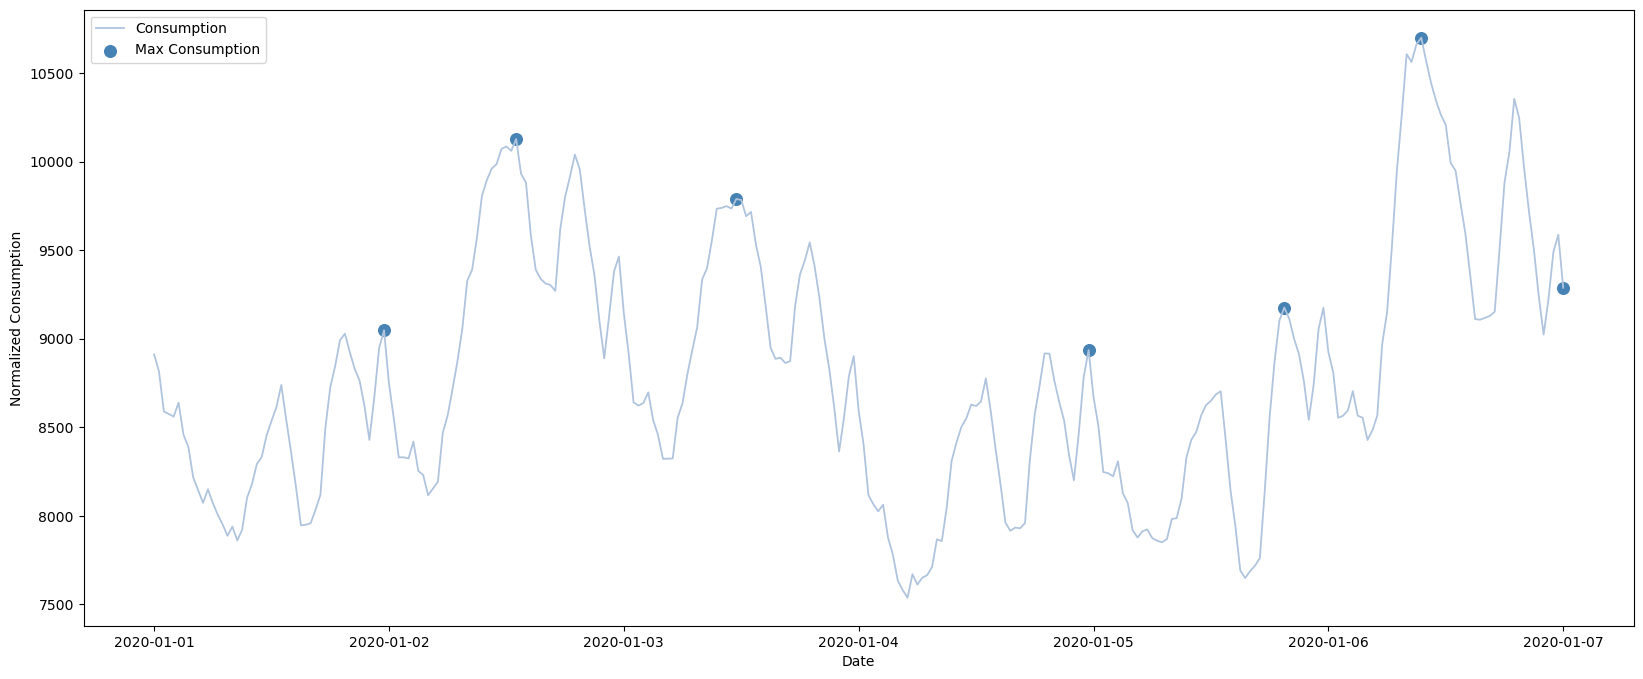

In [16]:
df_2019 = df[((df['time'].dt.year == 2020)) & (df['region'] == 'Auvergne-Rhône-Alpes')]
df_2019 = df_2019[df_2019['time'] <= pd.to_datetime('2020-01-07')]

max_consumption_per_day = df_2019.groupby(df_2019['time'].dt.date)['consumption'].idxmax()
max_consumption_data = df_2019.loc[max_consumption_per_day]

plt.figure(figsize=(20, 8))
plt.plot(df_2019['time'], df_2019['consumption'], label='Consumption', color='lightsteelblue', linewidth=1.3)
plt.scatter(max_consumption_data['time'], max_consumption_data['consumption'], color='steelblue', label='Max Consumption', s=70)

plt.xlabel('Date')
plt.ylabel('Normalized Consumption')
plt.legend(loc='upper left')
plt.show()

<br>

Correlation between temperature and consumption:

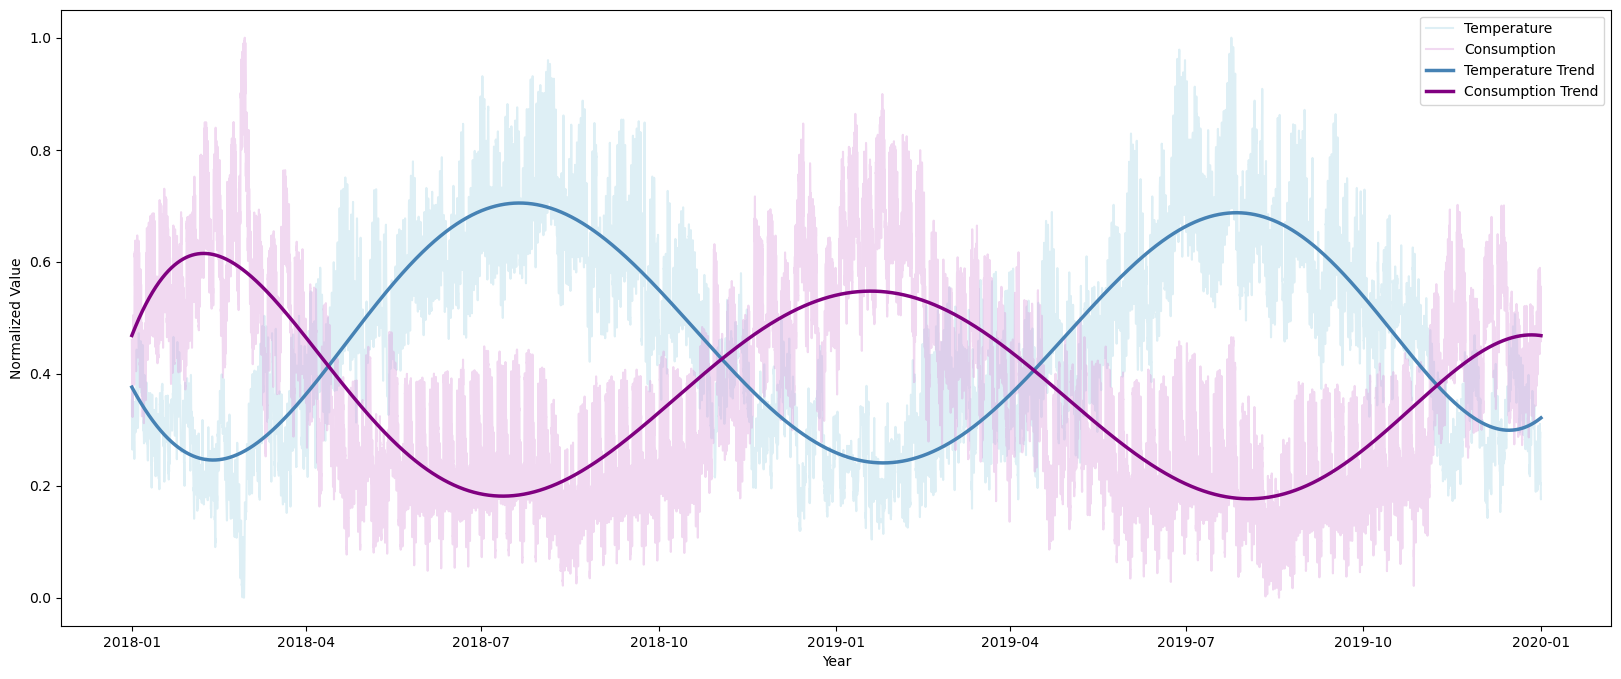

In [17]:
df_2019 = df[((df['time'].dt.year == 2019) | (df['time'].dt.year == 2018)) & (df['region'] == 'Auvergne-Rhône-Alpes')]

scaler = MinMaxScaler()
df_2019.loc[:, ['temperature', 'relative_humidity', 'apparent_temperature', 'consumption']] = scaler.fit_transform(df_2019[['temperature', 'relative_humidity', 'apparent_temperature', 'consumption']])

trend_temperature = np.polyfit(df_2019.index, df_2019['temperature'], 10)
trend_consumption = np.polyfit(df_2019.index, df_2019['consumption'], 10)

plt.figure(figsize=(20, 8))
plt.plot(df_2019['time'], df_2019['temperature'], label='Temperature', color='lightblue', alpha=0.4)
plt.plot(df_2019['time'], df_2019['consumption'], label='Consumption', color='plum', alpha=0.4)

plt.plot(df_2019['time'], np.polyval(trend_temperature, df_2019.index), label='Temperature Trend', linestyle='-', color='steelblue', linewidth=2.5)
plt.plot(df_2019['time'], np.polyval(trend_consumption, df_2019.index), label='Consumption Trend', linestyle='-', color='purple', linewidth=2.5)

plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

<br>

Correlation between humidity and consumption:

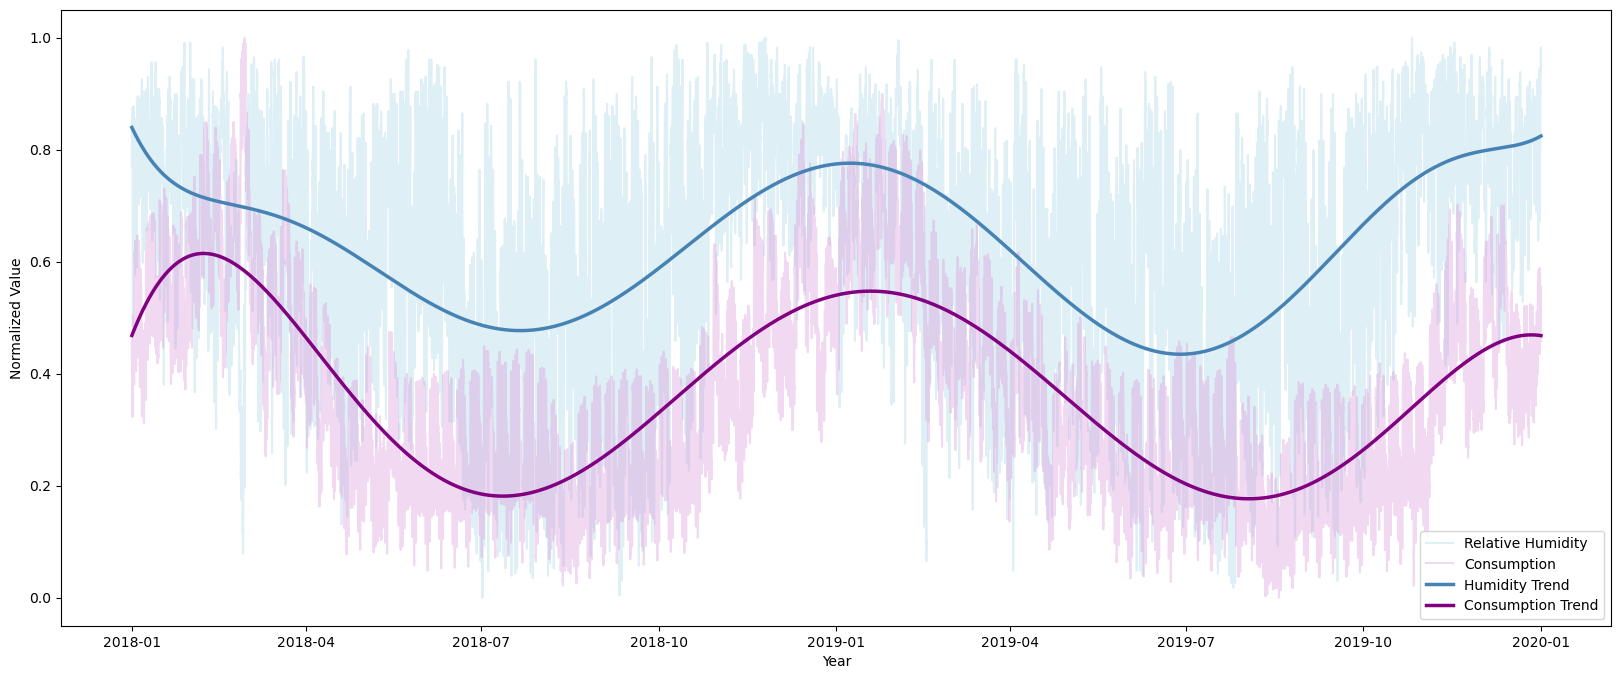

In [18]:
df_2019 = df[((df['time'].dt.year == 2019) | (df['time'].dt.year == 2018)) & (df['region'] == 'Auvergne-Rhône-Alpes')]

scaler = MinMaxScaler()
df_2019[['temperature', 'relative_humidity', 'apparent_temperature', 'consumption']] = scaler.fit_transform(df_2019[['temperature', 'relative_humidity', 'apparent_temperature', 'consumption']])

trend_humidity = np.polyfit(df_2019.index, df_2019['relative_humidity'], 10)
trend_consumption = np.polyfit(df_2019.index, df_2019['consumption'], 10)

plt.figure(figsize=(20, 8))
plt.plot(df_2019['time'], df_2019['relative_humidity'], label='Relative Humidity', color='lightblue', alpha=0.4)
plt.plot(df_2019['time'], df_2019['consumption'], label='Consumption', color='plum', alpha=0.4)

plt.plot(df_2019['time'], np.polyval(trend_humidity, df_2019.index), label='Humidity Trend', linestyle='-', color='steelblue', linewidth=2.5)
plt.plot(df_2019['time'], np.polyval(trend_consumption, df_2019.index), label='Consumption Trend', linestyle='-', color='purple', linewidth=2.5)

plt.xlabel('Year')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

<br>

Consumption distribution per region:

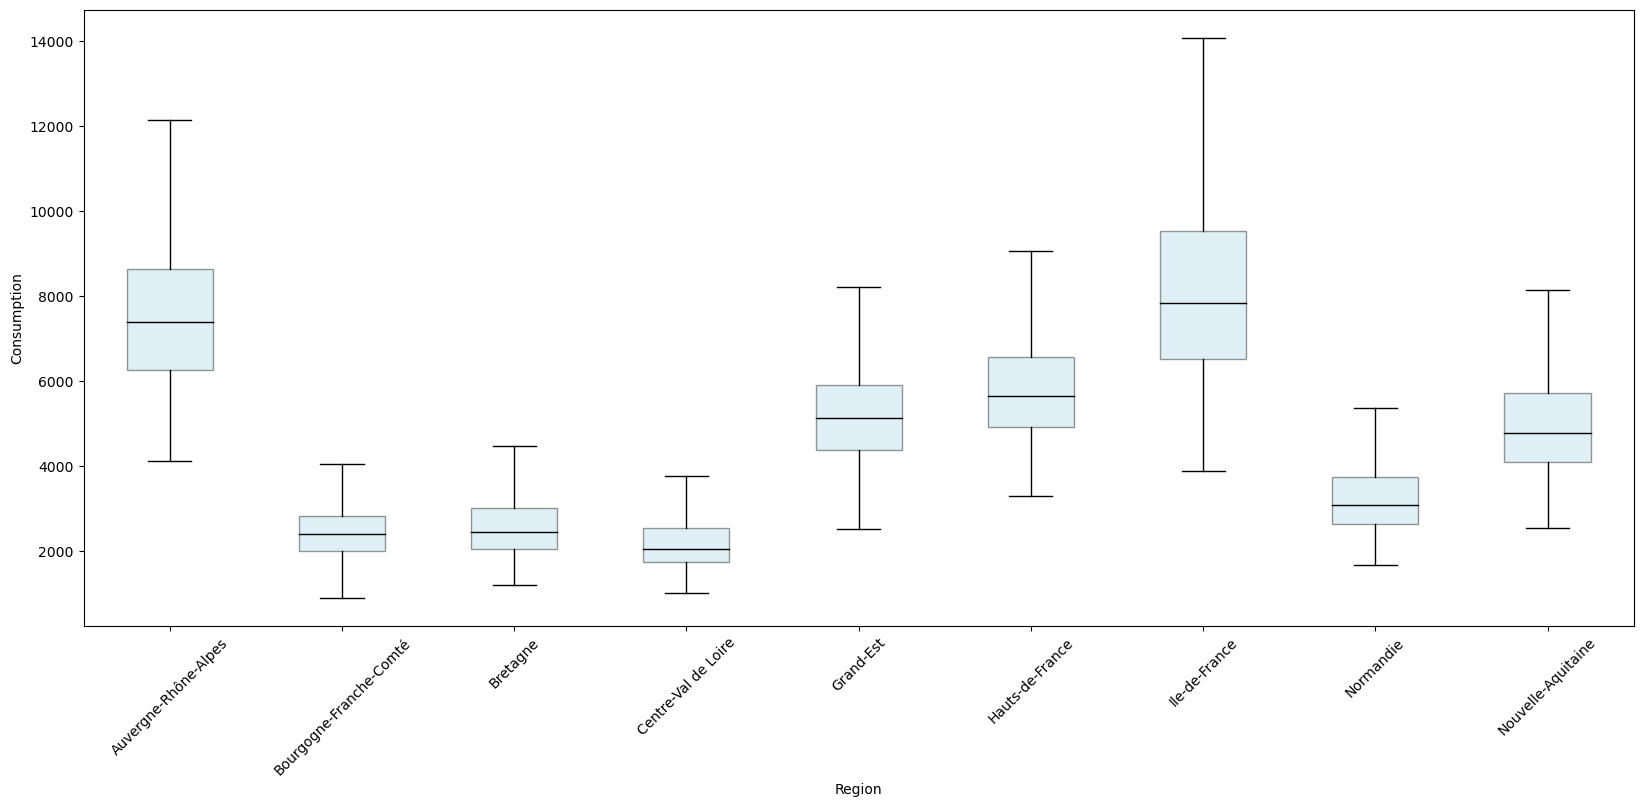

In [19]:
regions = df['region'].unique()

plt.figure(figsize=(20,8))
plt.boxplot([df[df['region'] == region]['consumption'] for region in regions], 
            labels=regions,
            showfliers=False, 
            patch_artist=True,  
            boxprops=dict(facecolor='lightblue', alpha = 0.4),  
            medianprops=dict(color='black'))
plt.xlabel('Region')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.show()